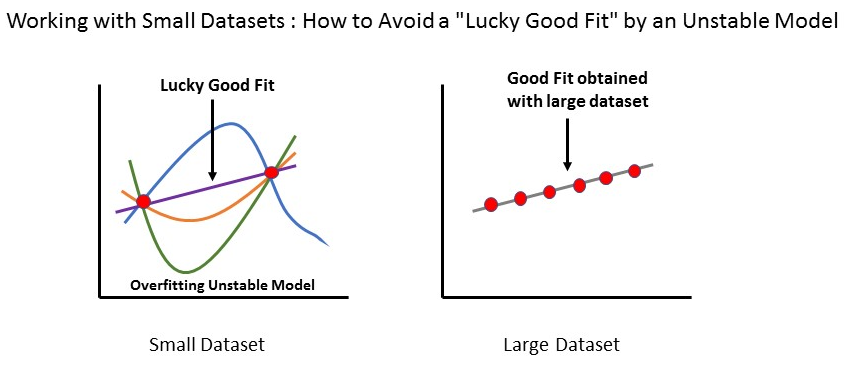

For optimal performance, it is essential to provide a large number of data points to the Machine Learning Models during the training stage. More data points signify more information and knowledge for the model. Consequently, the model can generate a good fit with more confidence. 
However, in certain situations such as Medical applications, many a time a data scientist or a machine learning engineer is assigned a small dataset to work with. When the dataset is small, the model can become unstable. The definition of an unstable model is **the one that is unable to give a robust constant result each time the model is executed**. This can also be interpreted as overfitting. That means that the model tries to overfit around whatever a small number of data points it is provided with. As a result, it loses its robustness and can give different results each time it is executed. We cannot trust the output of such an unstable model. 


However, it can so happen with small data sets that during the first execution itself the model produces a good fit showing high accuracy score for both training and test phase. Many times, beginners or even experienced machine learning engineers do this make of taking this high accuracy score as the result of the model and declaring it a “well-performing model” for the given dataset. However, it should be carefully noted that given a small dataset, this result can just be a **“lucky good fit”** of an unstable model performing overfitting (see the image above). 

The golden rule of selecting which model performs best with a given dataset is that there is no such rule. The performance of models is reliant on the dataset itself and one model can outperform others for a different dataset.
In this kernel, I will use the heart disease data to describe how to work around the problems of small data. We will try to find out which classification models are unstable for this dataset and how to avoid a lucky good fit from these models.


So Let's begin by loading some libraries

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math as ma

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

# Data Loading

In [ ]:
data = pd.read_csv('../input/heart.csv')

In [ ]:
data.head(5)

# Understanding the Data

In [ ]:
data.shape

This is a very small data. In the sections below we will try to figure out ways to detect unstable model for this data. But before that, lets try to understand the data itself. Lets find out if this a balanced data or not.

In [ ]:
data.groupby("target")['age'].count().plot.bar()

In [ ]:
y_value_counts = data['target'].value_counts()

print("Number of people getting heart attack ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of not getting heart attack ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")


This is a fairly balanced dataset.

In [ ]:
data.columns.values


# Data Cleaning

I am changing the names of the cloumn below so that I can have good understanding of the features later when I do Exploratory Data Analysis

In [ ]:
data.columns = ['age','sex','chestpain',
                     'blood_pressure','cholestoral','blood_sugar','ECG','max_heart_rate','angima','oldpeak','slope','coloured_vessels','thal','target']

In [ ]:
data.head(5)

Checking for Null or missing values

In [ ]:
data.info()

There are no missing or null values as all the column entrees have 303 non null values

We see that all the features have numerals as their column values. However, one should carefully understand that most of the features are actually categorical features as their values keep repeating. Most of them are ordinal categorical features having a clear order in the categories. For example chestpain feature has 4 values indicating pain levels from 0 to 3. I am changing them so that they are more apparent categorical features. This will help me diferentiate the numerical and categorical features for further analysis. Additionally, I will show one-hot encoding for categorical features in the coming sections for those who are iterested. 

In [ ]:
data['sex'][data['sex'] == 0] = 'Female'
data['sex'][data['sex'] == 1] = 'Male'

data['chestpain'][data['chestpain'] == 0] = 'level_zero'
data['chestpain'][data['chestpain'] == 1] = 'level_one'
data['chestpain'][data['chestpain'] == 2] = 'level_two'
data['chestpain'][data['chestpain'] == 3] = 'level_three'

data['blood_sugar'][data['blood_sugar'] == 0] = 'low'
data['blood_sugar'][data['blood_sugar'] == 1] = 'high'

data['ECG'][data['ECG'] == 0] = 'normal'
data['ECG'][data['ECG'] == 1] = 'wave_abnormality'
data['ECG'][data['ECG'] == 2] = 'Estes_criteria'

data['angima'][data['angima'] == 0] = 'No'
data['angima'][data['angima'] == 1] = 'Yes'

data['slope'][data['slope'] == 0] = 'Upsloping'
data['slope'][data['slope'] == 1] = 'Flat'
data['slope'][data['slope'] == 2] = 'Downsloping'

data['thal'][data['thal'] == 0] = 'level_zero'
data['thal'][data['thal'] == 1] = 'level_one'
data['thal'][data['thal'] == 2] = 'level_two'
data['thal'][data['thal'] == 3] = 'level_three'

data['coloured_vessels'][data['coloured_vessels'] == 0] = 'zero'
data['coloured_vessels'][data['coloured_vessels'] == 1] = 'one'
data['coloured_vessels'][data['coloured_vessels'] == 2] = 'two'
data['coloured_vessels'][data['coloured_vessels'] == 3] = 'three'
data['coloured_vessels'][data['coloured_vessels'] == 4] = 'four'

data.head(5)

Now the data looks better so we can proceed to do some exploratory data analysis for understanding the features in the data

# Exploratory Data Analysis

I will perform univariate analysis i.e taking single features and understanding how they help in the classfication task of separating two classes (target 0: no heart attack and target 1: heart attack).

## Univariate Analysis

### 1. Numerical features

For the numerical features we can plot pdf and box plots to understand their contribution in the classification task

#### Age 

Here I want to check if feature "age"  is able to seperate the two classes.

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'target', y = 'age', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['target'] == 0.0]['age'][0:] , label = "0", color = 'red')
sns.distplot(data[data['target'] == 1.0]['age'][0:] , label = "1" , color = 'blue' )
plt.legend()
plt.show()

We see that the two pdfs on the right curve have a slight seperation. This can also be seen in the box plot on the left. Typically, if one box plot is much higher or lower than another, that indicates that the feature will be important in the classification

#### Blood Pressure

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.boxplot(x = 'target', y = 'blood_pressure', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['target'] == 0.0]['blood_pressure'][0:] , label = "0", color = 'red')
sns.distplot(data[data['target'] == 1.0]['blood_pressure'][0:] , label = "1" , color = 'blue' )
plt.legend()
plt.show()

For the blood pressure, we see that the pdfs are mostly overlapping and similarly the box plot medians (middle line of the box) have the same level. Therefore this feature might not be very useful in classification.

#### Cholestrol

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'target', y = 'cholestoral', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['target'] == 0.0]['cholestoral'][0:] , label = "0", color = 'red')
sns.distplot(data[data['target'] == 1.0]['cholestoral'][0:] , label = "1" , color = 'blue' )
plt.legend()
plt.show()

For cholestrol, there is only a sight gap in the box plots

#### Maximum heart rate

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'target', y = 'max_heart_rate', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['target'] == 0.0]['max_heart_rate'][0:] , label = "0", color = 'red')
sns.distplot(data[data['target'] == 1.0]['max_heart_rate'][0:] , label = "1" , color = 'blue' )
plt.legend()
plt.show()

Maximum heart rate is an important feature for classification as seen in the level difference of box plots and less overlap in the pdfs

#### Oldpeak

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'target', y = 'oldpeak', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['target'] == 0.0]['oldpeak'][0:] , label = "0", color = 'red')
sns.distplot(data[data['target'] == 1.0]['oldpeak'][0:] , label = "1" , color = 'blue' )
plt.legend()
plt.show()

Old peak is also an important feature for classification as seen in the level difference of box plots and seperation in the pdfs. It can also be noted that most of people who had heart attack had an old peak value of less than 1. To give the exact numbers I will list down bellow the percentiles for this feature.

In [ ]:
heart_attack = data[data['target']==1]['oldpeak'].values
no_heart_attack = data[data['target']==0]['oldpeak'].values


from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Heart Attack", "No Heart attack"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(heart_attack,i), 3), np.round(np.percentile(no_heart_attack,i), 3)])
print(x)

Looking at the 75th percentile, 75% people who had heart attack had old peak less than 1.

### 2. Categorical features

Now lets see how categorical features help in performing the classification

In [ ]:
def stack_plot(data, xtick, col2='heart attack cases', col3='total cases'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(10,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Number of people')
    plt.title('Heart Attack Vs No Heart Attack')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total cases', 'heart attack cases'))
    plt.show()

In [ ]:
def univariate_barplots(data, col1, col2='target', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
   
    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']

    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    

    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))


#### sex

In [ ]:
univariate_barplots(data, 'sex', 'target' , top=False)

Here we can conclude that 75% of total women in the dataset had heartattack as compared to 45% of total men. Even when we have less number of data for women, we see that this category dominates for class 1.

#### Chestpain

In [ ]:
univariate_barplots(data, 'chestpain', 'target' , top=False)

Out of the people who had zero level of chest pain only 27% had heart attack as compared to 80% of people who had level two chest pain

#### blood_sugar

In [ ]:
univariate_barplots(data, 'blood_sugar', 'target' , top=False)

Blood sugar does not give much information in the classification as nearly 50% of people had attack for both high or low sugar categories. Also we do not have enough data for high blood sugar category to actually make comparision.

#### ECG

In [ ]:
univariate_barplots(data, 'ECG', 'target' , top=False)

For categories of people which show wave abnormality in their ECG around 63% people had heartattack as compared to 46% of people who had normal ECG. Since we have very few data points for estes criteria we cannot really conclude anything on that

#### angima

In [ ]:
univariate_barplots(data, 'angima', 'target' , top=False)

70% of people who did not have exercise induced angima had heartattack

#### slope

In [ ]:
univariate_barplots(data, 'slope', 'target' , top=False)

Most of personnels (75%) which had downslopping in their peak exercise ST segment had heart attack.

#### coloured_vessels

In [ ]:
univariate_barplots(data, 'coloured_vessels', 'target' , top=False)

Here, we should be careful in concluding that majority of people who had heart attack had zero coloured vessels in flouroscopy as majority of data we have has only this category

#### thal

In [ ]:
univariate_barplots(data, 'thal', 'target' , top=False)

Out of total people who had level two thalassemia had heartattack.

# Splitting of Data for test and Training

In [ ]:
y = data['target']
data.drop(['target'], axis=1, inplace=True)
X=data
print(X.shape)
print(y.shape)

#### Use of K-fold cross validation on small data set.

The first important step that I want to mention which will help us in getting around with small data sets is to use K- fold cross validation instead of simple validation. In k-fold cross validation we **do not** explicitly keep aside a part of the data to perform validation. We only separate the whole data into two sets that is training set and test set. Quoting from the Wikipedia “The training data is randomly sampled into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for evaluating the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation”. Therefore, the advantage of this method is that we are able to use more data points for training.

Therefore below I am splitting the data only as training and test and I will use GridSearchCV to perform k-fold cross validation.

In [ ]:
#Split the data into train and test

X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
print(X_tr.shape)
print(y_tr.shape)
print(X_test.shape)
print(y_test.shape)

# Standardization of Numerical features

 Before executing any machine learning algorithm, we should perform scaling of the numerical feature. Scaling in simple terms means bringing all the features to the same level. It is a crucial step because if the numerical features have different scales with one feature having large values and nother features having small values, then their effects on the algorithm will be different. There are some algorithms that can negate the effect of scaling. Nevertheless, it is a good practice to always perform scaling on the numerical features for every machine learning algorithm.  Here I will be doing the standardization which is also called "mean centering and scaling".  For standardization, for a given feature or column in the training data, we calculate its mean and standard deviation and then the column values are changed as

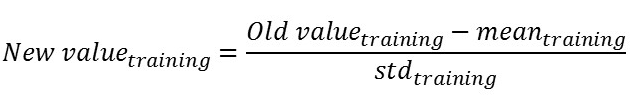

It should be noted for a given feature in the test data, we should do the feature scale as below

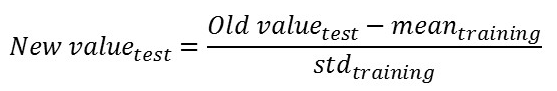

Note that we have used the mean and standard deviation for the **training data** for a given feature of test data set. This is essential to avoid data leakage. Test data is like the unseen data we will encounter after deployment of our model. Therefore do adapt our models for unseen data we do not use any attribute of test data during training phase.

#### age

In [ ]:
from sklearn.preprocessing import StandardScaler
age_scalar = StandardScaler(with_mean=False)
age_scalar.fit(X_tr['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {age_scalar.mean_[0]}, Standard deviation : {np.sqrt(age_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_age_standardized = age_scalar.transform(X_tr['age'].values.reshape(-1, 1))
Test_age_standardized = age_scalar.transform(X_test['age'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_age_standardized.shape)
print(Test_age_standardized.shape)

#### blood_pressure

In [ ]:
blood_pressure_scalar = StandardScaler(with_mean=False)
blood_pressure_scalar.fit(X_tr['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {blood_pressure_scalar.mean_[0]}, Standard deviation : {np.sqrt(blood_pressure_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_blood_pressure_standardized = blood_pressure_scalar.transform(X_tr['blood_pressure'].values.reshape(-1, 1))
Test_blood_pressure_standardized = blood_pressure_scalar.transform(X_test['blood_pressure'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_blood_pressure_standardized.shape)
print(Test_blood_pressure_standardized.shape)

#### cholestoral

In [ ]:
cholestoral_scalar = StandardScaler(with_mean=False)
cholestoral_scalar.fit(X_tr['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {cholestoral_scalar.mean_[0]}, Standard deviation : {np.sqrt(cholestoral_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_cholestoral_standardized = cholestoral_scalar.transform(X_tr['cholestoral'].values.reshape(-1, 1))
Test_cholestoral_standardized = cholestoral_scalar.transform(X_test['cholestoral'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_cholestoral_standardized.shape)
print(Test_cholestoral_standardized.shape)

#### max_heart_rate

In [ ]:
max_heart_rate_scalar = StandardScaler(with_mean=False)
max_heart_rate_scalar.fit(X_tr['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {max_heart_rate_scalar.mean_[0]}, Standard deviation : {np.sqrt(max_heart_rate_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_max_heart_rate_standardized = cholestoral_scalar.transform(X_tr['max_heart_rate'].values.reshape(-1, 1))
Test_max_heart_rate_standardized = cholestoral_scalar.transform(X_test['max_heart_rate'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_max_heart_rate_standardized.shape)
print(Test_max_heart_rate_standardized.shape)

#### oldpeak

In [ ]:
oldpeak_scalar = StandardScaler(with_mean=False)
oldpeak_scalar.fit(X_tr['oldpeak'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {oldpeak_scalar.mean_[0]}, Standard deviation : {np.sqrt(oldpeak_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_oldpeak_standardized = cholestoral_scalar.transform(X_tr['oldpeak'].values.reshape(-1, 1))
Test_oldpeak_standardized = cholestoral_scalar.transform(X_test['oldpeak'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_oldpeak_standardized.shape)
print(Test_oldpeak_standardized.shape)

# One hot encoding of categorical features

Now we perform one hot encoding of the categorical features

In [ ]:
def One_hot_encoding_tr(col):
    my_counter = Counter()
    for word in col.values:
        my_counter.update(word.split())

    col_dict = dict(my_counter)
    sorted_col_dict = dict(sorted(col_dict.items(), key=lambda kv: kv[1])) # sort categories in desc order as a dictionary

    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=list(sorted_col_dict.keys()), lowercase=False, binary=True)
    vectorizer.fit(col.values)
    print(vectorizer.get_feature_names())
    
    Tr_col_one_hot = vectorizer.transform(col.values)
    return Tr_col_one_hot

def One_hot_encoding_test(col,test_col):
    my_counter = Counter()
    for word in col.values:
        my_counter.update(word.split())

    col_dict = dict(my_counter)
    sorted_col_dict = dict(sorted(col_dict.items(), key=lambda kv: kv[1])) # sort categories in desc order as a dictionary

    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=list(sorted_col_dict.keys()), lowercase=False, binary=True)
    vectorizer.fit(col.values)
    print(vectorizer.get_feature_names())
    
    Tr_col_one_hot = vectorizer.transform(col.values)
    Test_col_one_hot = vectorizer.transform(test_col.values)
    return Test_col_one_hot




#### sex

In [ ]:
Tr_sex_one_hot=One_hot_encoding_tr(X_tr['sex'])
Test_sex_one_hot=One_hot_encoding_test(X_tr['sex'],X_test['sex'])
print("Shape of matrix after one hot encoding")
print(Tr_sex_one_hot.shape)
print(Test_sex_one_hot.shape)

#### Chestpain

In [ ]:
Tr_chestpain_one_hot=One_hot_encoding_tr(X_tr['chestpain'])
Test_chestpain_one_hot=One_hot_encoding_test(X_tr['chestpain'],X_test['chestpain'])
print("Shape of matrix after one hot encoding")
print(Tr_chestpain_one_hot.shape)
print(Test_chestpain_one_hot.shape)

#### blood_sugar

In [ ]:
Tr_blood_sugar_one_hot=One_hot_encoding_tr(X_tr['blood_sugar'])
Test_blood_sugar_one_hot=One_hot_encoding_test(X_tr['blood_sugar'],X_test['blood_sugar'])
print("Shape of matrix after one hot encoding")
print(Tr_blood_sugar_one_hot.shape)
print(Test_blood_sugar_one_hot.shape)

#### ECG

In [ ]:
Tr_ECG_one_hot=One_hot_encoding_tr(X_tr['ECG'])
Test_ECG_one_hot=One_hot_encoding_test(X_tr['ECG'],X_test['ECG'])
print("Shape of matrix after one hot encoding")
print(Tr_ECG_one_hot.shape)
print(Test_ECG_one_hot.shape)

#### angima

In [ ]:
Tr_angima_one_hot=One_hot_encoding_tr(X_tr['angima'])
Test_angima_one_hot=One_hot_encoding_test(X_tr['angima'],X_test['angima'])
print("Shape of matrix after one hot encoding")
print(Tr_angima_one_hot.shape)
print(Test_angima_one_hot.shape)

#### slope

In [ ]:
Tr_slope_one_hot=One_hot_encoding_tr(X_tr['slope'])
Test_slope_one_hot=One_hot_encoding_test(X_tr['slope'],X_test['slope'])
print("Shape of matrix after one hot encoding")
print(Tr_slope_one_hot.shape)
print(Test_slope_one_hot.shape)

#### coloured_vessels

In [ ]:
Tr_coloured_vessels_one_hot=One_hot_encoding_tr(X_tr['coloured_vessels'])
Test_coloured_vessels_one_hot=One_hot_encoding_test(X_tr['coloured_vessels'],X_test['coloured_vessels'])
print("Shape of matrix after one hot encoding")
print(Tr_coloured_vessels_one_hot.shape)
print(Test_coloured_vessels_one_hot.shape)

#### thal

In [ ]:
Tr_thal_one_hot=One_hot_encoding_tr(X_tr['thal'])
Test_thal_one_hot=One_hot_encoding_test(X_tr['thal'],X_test['thal'])
print("Shape of matrix after one hot encoding")
print(Tr_thal_one_hot.shape)
print(Test_thal_one_hot.shape)

# Applying classification Models

In [ ]:
from scipy.sparse import hstack
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pylab
from matplotlib.pyplot import figure
##https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

Combining all features together using hstack.

In [ ]:
train = hstack((Tr_age_standardized,Tr_blood_pressure_standardized,Tr_cholestoral_standardized,Tr_chestpain_one_hot,Tr_blood_sugar_one_hot,Tr_ECG_one_hot,Tr_angima_one_hot,
            Tr_slope_one_hot,Tr_coloured_vessels_one_hot,Tr_thal_one_hot,Tr_max_heart_rate_standardized,Tr_oldpeak_standardized,Tr_sex_one_hot
             
           )) 

test = hstack((Test_age_standardized,Test_blood_pressure_standardized,Test_cholestoral_standardized,Test_chestpain_one_hot,Test_blood_sugar_one_hot,Test_ECG_one_hot,Test_angima_one_hot,
            Test_slope_one_hot,Test_coloured_vessels_one_hot,Test_thal_one_hot,Test_max_heart_rate_standardized,Test_oldpeak_standardized,Test_sex_one_hot
             
           )) 
print(train.shape)
print(test.shape)

#### Checking robostness of models for small data sets by executing the same model multiple times

Now we apply classification algorithm on this small dataset of 303 rows. One simple trick to check the stability of these models is to run each model multiple times and note if the parameters of the model vary a lot. If the training score, test score and fitting parameters of model have big differences in their values during each execution of the model that indicates that the model is unstable and can be overfitting. 

For example, let’s assume one model gives a training AUC score of 0.88 and test AUC score of 0.85 in one run and then in another run it gives a training AUC of 0.65 and test AUC of 0.63 that means the model is not stable. As we will see below that this is indeed the case for several models on this small dataset.

Running the model multiple times is affordable in case of small datasets as the time complexity is not very high

In the coming sections, I will execute each model 10 times and store the fitting parameters and score from the model in lists and later I will plot them. The iteration number in the x-axis of plots indicates the execution number of the model. For example, execution number=3 means 3rd time the model is executed.

I am using simple AUC score for evaluating the model as this is a balanced dataset thus AUC score should not be affected.

## 1. Logistic Regression

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

lamda=list()
test_auc=list()
training_auc=list()
cv_auc=list()

iteration=np.arange(1,10)
for i in range(1,10):

    k=[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

    param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

    #Hyper parameter Tuning for lamda with 3 fold cross validation
    clf = linear_model.SGDClassifier(loss='log')

    clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

    clf_cv.fit(train.toarray(),y_tr)
    cv_auc.append(clf_cv.best_score_)
    
    #Instantiate Classifier
    clf = linear_model.SGDClassifier(loss='log',alpha=clf_cv.best_params_.get('alpha'))
    clf.fit(train.toarray(),y_tr)
    y_pred_proba_test = clf.predict_proba(test.toarray())[:,1]
    y_pred_proba_tr = clf.predict_proba(train.toarray())[:,1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
   
    test_auc.append(roc_auc_score(y_test,y_pred_proba_test))
    training_auc.append(roc_auc_score(y_tr,y_pred_proba_tr))
    lamda.append(clf_cv.best_params_.get('alpha'))

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.subplot(2,2,1)    
pylab.plot(iteration, training_auc, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Training AUC')
pylab.grid()


pylab.subplot(2,2,2)
pylab.plot(iteration, test_auc, '-b', label='Test AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('test AUC')
pylab.grid()


pylab.subplot(2,2,3)
pylab.plot(iteration, cv_auc, '-b', label='CV AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('CV AUC')
pylab.grid()

pylab.subplot(2,2,4)
pylab.plot(iteration, lamda, '-b', label='Lambda',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Lambda')
pylab.yscale("log")
pylab.grid()
pylab.show()



In the plots above, we clearly see that the logistic regression model is not stable for this dataset. We see that even the training score varies between 0.65 to 0.9 indicating a high variance in this model or overfitting. Therefore even after performing hyperparameter tuning, we see that we can still overfit our models when we have small datasets. Similarly, lamda which is the regularisation parameter, varies a lot for each execuation of the model. if we had run our model only once and if we had acheived a high score we would have concluded that logistic regression works very well for this model. This is a common mistake. **Therefore we should not rely on a lucky guess in case of small datasets**.
Logistic regression is often a first choice of model for many machine learning engineers and is considered a flexible model however with this data set, logistic regression is not a good choice.

## 2. KNN

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from sklearn.neighbors import KNeighborsClassifier
k_nn=list()
test_auc=list()
training_auc=list()
cv_auc=list()

iteration=np.arange(1,10)

k=np.arange(1,70,5)
param_grid = {'n_neighbors':np.arange(1,70,5)}

for i in range(1,10):


    #Hyper parameter Tuning for lamda with 3 fold cross validation
    clf = KNeighborsClassifier(algorithm='brute')

    clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

    clf_cv.fit(train.toarray(),y_tr)
    cv_auc.append(clf_cv.best_score_)
    
    #Instantiate Classifier
    clf = KNeighborsClassifier(n_neighbors=clf_cv.best_params_.get('n_neighbors'),algorithm='brute')
    clf.fit(train.toarray(),y_tr)
    y_pred_proba_test = clf.predict_proba(test.toarray())[:,1]
    y_pred_proba_tr = clf.predict_proba(train.toarray())[:,1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
   
    test_auc.append(roc_auc_score(y_test,y_pred_proba_test))
    training_auc.append(roc_auc_score(y_tr,y_pred_proba_tr))
    k_nn.append(clf_cv.best_params_.get('n_neighbors'))
    
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.subplot(2,2,1)    
pylab.plot(iteration, training_auc, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Training AUC')
pylab.grid()


pylab.subplot(2,2,2)
pylab.plot(iteration, test_auc, '-b', label='Test AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('test AUC')
pylab.grid()


pylab.subplot(2,2,3)
pylab.plot(iteration, cv_auc, '-b', label='CV AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('CV AUC')
pylab.grid()

pylab.subplot(2,2,4)
pylab.plot(iteration, k_nn, '-b', label='Number of nearest neighbours',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Number of nearest neighbours')
pylab.grid()
pylab.show()

Here we see that KNN is a stable model for this data set because the score and parameter value remain constant for this model. It gives a test score of nearly 0.82.

## 3. Naive Bayes

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from sklearn.naive_bayes import MultinomialNB

alpha_list=list()
test_auc=list()
training_auc=list()
cv_auc=list()

iteration=np.arange(1,10)

param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

for i in range(1,10):


    #Hyper parameter Tuning for lamda with 3 fold cross validation
    clf = MultinomialNB()

    clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

    clf_cv.fit(train.toarray(),y_tr)
    cv_auc.append(clf_cv.best_score_)
    
    #Instantiate Classifier
    clf = MultinomialNB(alpha=clf_cv.best_params_.get('alpha'))
    clf.fit(train.toarray(),y_tr)
    y_pred_proba_test = clf.predict_proba(test.toarray())[:,1]
    y_pred_proba_tr = clf.predict_proba(train.toarray())[:,1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
   
    test_auc.append(roc_auc_score(y_test,y_pred_proba_test))
    training_auc.append(roc_auc_score(y_tr,y_pred_proba_tr))
    alpha_list.append(clf_cv.best_params_.get('alpha'))
    
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.subplot(2,2,1)    
pylab.plot(iteration, training_auc, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Training AUC')
pylab.grid()


pylab.subplot(2,2,2)
pylab.plot(iteration, test_auc, '-b', label='Test AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('test AUC')
pylab.grid()


pylab.subplot(2,2,3)
pylab.plot(iteration, cv_auc, '-b', label='CV AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('CV AUC')
pylab.grid()

pylab.subplot(2,2,4)
pylab.plot(iteration, alpha_list, '-b', label='Alpha',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('alpha')
pylab.grid()
pylab.show()
    


Similarly, we see that naive bayes is also a stable model on this dataset giving a high test score of nearly 0.92

## 4. Linear Support Vector Machine (SVM)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from sklearn.calibration import CalibratedClassifierCV

alpha_list=list()
test_auc=list()
training_auc=list()
cv_auc=list()

iteration=np.arange(1,10)

param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

for i in range(1,10):


    #Hyper parameter Tuning for lamda with 3 fold cross validation
    clf = linear_model.SGDClassifier(loss='hinge')

    clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

    clf_cv.fit(train.toarray(),y_tr)
    
    cv_auc.append(clf_cv.best_score_)
    
    #Instantiate Classifier
    clf = linear_model.SGDClassifier(loss='hinge',alpha=clf_cv.best_params_.get('alpha'))
    calibrated = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated.fit(train.toarray(),y_tr)

    y_pred_proba_test = calibrated.predict_proba(test.toarray())[:, 1]
    y_pred_proba_tr = calibrated.predict_proba(train.toarray())[:, 1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
   
    test_auc.append(roc_auc_score(y_test,y_pred_proba_test))
    training_auc.append(roc_auc_score(y_tr,y_pred_proba_tr))
    alpha_list.append(clf_cv.best_params_.get('alpha'))
    

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.subplot(2,2,1)
pylab.plot(iteration, training_auc, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Training AUC')
pylab.grid()



pylab.subplot(2,2,2)
pylab.plot(iteration, test_auc, '-b', label='Test AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('test AUC')
pylab.grid()


pylab.subplot(2,2,3)
pylab.plot(iteration, cv_auc, '-b', label='CV AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('CV AUC')
pylab.grid()


pylab.subplot(2,2,4)
pylab.plot(iteration, alpha_list, '-b', label='Alpha',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('alpha')
pylab.yscale("log")
pylab.grid()
pylab.show()



Here, we see that score and parmeter of linear SVM also varry while running the model multiple times. However, if we have a look at the scale of the test AUC score we see that this variation is not as much as we saw in logistic regression

So, far we have noticed that the linear models such as logistic regression and linear SVM are unstable for this small dataset. The reason could lie in the non-linearity of the dataset. Linear models assume that linear a surface such as a hyperplane will be able to seperate the two classes of data. This may not be true in this dataset. 

We can test this by running a non-linear SVM model using RBF kernel. If we are alble to stabilise our results that means that indeed linearity is the cause. 

## 5 Non-linear SVM

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from sklearn.svm import SVC
c_list=list()
gamma_list=list()
test_auc=list()
training_auc=list()
cv_auc=list()

iteration=np.arange(1,10)

param_grid = {'C':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
              'gamma':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

for i in range(1,10):


    #Hyper parameter Tuning for lamda with 3 fold cross validation
    clf = SVC(kernel='rbf',probability=True)

    clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

    clf_cv.fit(train.toarray(),y_tr)
    cv_auc.append(clf_cv.best_score_)
    
    #Instantiate Classifier
    clf = SVC(kernel='rbf', gamma=clf_cv.best_params_.get('gamma'), C=clf_cv.best_params_.get('C'),probability=True)
    clf.fit(train.toarray(),y_tr)
    y_pred_proba_test = clf.predict_proba(test.toarray())[:,1]
    y_pred_proba_tr = clf.predict_proba(train.toarray())[:,1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
   
    test_auc.append(roc_auc_score(y_test,y_pred_proba_test))
    training_auc.append(roc_auc_score(y_tr,y_pred_proba_tr))
    c_list.append(clf_cv.best_params_.get('C'))
    gamma_list.append(clf_cv.best_params_.get('gamma'))
    
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.subplot(3,2,1)    
pylab.plot(iteration, training_auc, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('Training AUC')
pylab.grid()


pylab.subplot(3,2,2)
pylab.plot(iteration, test_auc, '-b', label='Test AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('test AUC')
pylab.grid()


pylab.subplot(3,2,3)
pylab.plot(iteration, cv_auc, '-b', label='CV AUC',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('CV AUC')
pylab.grid()

pylab.subplot(3,2,4)
pylab.plot(iteration, c_list, '-b', label='C',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('c')
pylab.grid()


pylab.subplot(3,2,5)
pylab.plot(iteration, gamma_list, '-b', label='gamma',linewidth=2.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Execution number')
pylab.ylabel('gamma')
pylab.grid()
pylab.show()
    



Above, we see that non linear SVM with RBF kernel is stable for this dataset giving a high test AUC score of around 0.92 nearly same as Naive Bayes algorithm. 

# Conclusion

Working with small datasets can be tricky as models can easily overfit. One must be careful in selecting the correct model for a given dataset and not fall for the lucky fit guess by an unstable model.